# Load library

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import rasterio
import matplotlib.pyplot as plt
from joblib import dump, load
from extract_func.Extract_PTE_function import *

2023-02-23 12:33:46.936302: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Get Weather model

In [7]:
wm = xr.load_dataset('../GNSS/Global_dat/Full_Global_data/WM_files/ERA-5_2017_01_01_T00_00_00_90S_90N_180W_180E.nc')
wm

<xarray.Dataset>
Dimensions:      (x: 1437, y: 717, z: 32)
Coordinates:
  * x            (x) float64 -179.6 -179.4 -179.1 -178.9 ... 178.9 179.1 179.4
  * y            (y) float64 -89.6 -89.35 -89.1 -88.85 ... 88.65 88.9 89.15 89.4
  * z            (z) float32 -500.0 -300.0 -200.0 ... 4.374e+04 4.841e+04
Data variables:
    WGS84        |S1 b''
    latitude     (z, y, x) float64 -3.403e+38 -3.403e+38 ... -3.403e+38
    longitude    (z, y, x) float64 -3.403e+38 -3.403e+38 ... -3.403e+38
    t            (z, y, x) float32 265.7 265.7 265.7 265.7 ... 248.8 248.8 248.8
    p            (z, y, x) float32 9.895e+04 9.895e+04 9.895e+04 ... 163.2 163.2
    e            (z, y, x) float32 78.24 78.24 78.24 ... -0.0005878 -0.000588
    wet          (z, y, x) float32 4.224 4.224 4.224 ... -3.615e-05 -3.617e-05
    hydro        (z, y, x) float32 289.0 289.0 289.0 ... 0.5088 0.5088 0.5088
    wet_total    (z, y, x) float32 0.0212 0.0212 0.0212 0.02119 ... 0.0 0.0 0.0
    hydro_total  (z, y, x) float32 2.44 2.44 2.44 2.44 2.44 ... 0.0 0.0 0.0 0.0
Attributes:
    Conventions:   CF-1.6
    datetime:      2017_01_01T00_00_00
    date_created:  2023_01_21T15_18_24
    title:         Weather model data and delay calculations

# Load ML model

In [2]:
import tensorflow as tf
model = tf.keras.models.load_model('Model/global_PTE_fixed_hgtlvs_02_20_model/')

2023-02-23 12:34:12.729785: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_84 (Dense)            (None, 155)               24180     
                                                                 
 p_re_lu_7 (PReLU)           (None, 155)               155       
                                                                 
 dropout_77 (Dropout)        (None, 155)               0         
                                                                 
 dense_85 (Dense)            (None, 155)               24180     
                                                                 
 dropout_78 (Dropout)        (None, 155)               0         
                                                                 
 dense_86 (Dense)            (None, 80)                12480     
                                                                 
 dropout_79 (Dropout)        (None, 80)               

In [4]:
scaler = load('Scaler/global_MinMax_scaler_x.bin')

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Test on InSAR application

For the testing of InSAR application of the trained model, we take the area of Pennsylvania and compare the performance of RF, NN, and RAiDER prediction

In [5]:
import glob
import rasterio
import numpy as np
import pandas as pd

In [6]:
weather_file_path = '../InSAR/Pennsylvania/WM_files/'
uw_ifg = '../InSAR/Pennsylvania/Extracted/unwrappedPhase/'
coh_ifg = '../InSAR/Pennsylvania/Extracted/coherence/'

In [7]:
dates = glob.glob(uw_ifg+'????????_????????')

In [8]:
dates.sort()
dates[::5]

['../InSAR/Pennsylvania/Extracted/unwrappedPhase/20200212_20200131',
 '../InSAR/Pennsylvania/Extracted/unwrappedPhase/20200412_20200331',
 '../InSAR/Pennsylvania/Extracted/unwrappedPhase/20200611_20200530',
 '../InSAR/Pennsylvania/Extracted/unwrappedPhase/20200810_20200729',
 '../InSAR/Pennsylvania/Extracted/unwrappedPhase/20201009_20200927',
 '../InSAR/Pennsylvania/Extracted/unwrappedPhase/20201208_20201126']

In [137]:
ifg__ = rasterio.open(dates[::2][0])
ifg__.bounds

BoundingBox(left=-79.9608333333334, bottom=38.7641666666667, right=-75.9608333333334, top=43.2716666666667)

In [9]:
coh_list = []
for path in glob.glob(coh_ifg+'*[0-9].vrt'):
    with rasterio.open(path) as file:
        coh_ = file.read(1)
        coh_[coh_==0] = np.nan
        avg_coh = np.nanmean(coh_)
        if avg_coh > 0.8:
            coh_list.append(path.split('/')[-1].split('.')[0])
        else:
            pass

In [10]:
ifg_list = [e for e in coh_list if e in [i.split('/')[-1] for i in dates]]
ifg_list.sort()
ifg_list

['20200212_20200131',
 '20200307_20200224',
 '20200319_20200307',
 '20200331_20200319',
 '20200412_20200331',
 '20200424_20200412',
 '20200506_20200424',
 '20201126_20201114']

In [19]:
wm_date = [i.split('_') for i in ifg_list]
wm_date = [item for sublist in wm_date for item in sublist]
wm_date.sort()
wm_date

['20200131',
 '20200212',
 '20200224',
 '20200307',
 '20200307',
 '20200319',
 '20200319',
 '20200331',
 '20200331',
 '20200412',
 '20200412',
 '20200424',
 '20200424',
 '20200506',
 '20201114',
 '20201126']

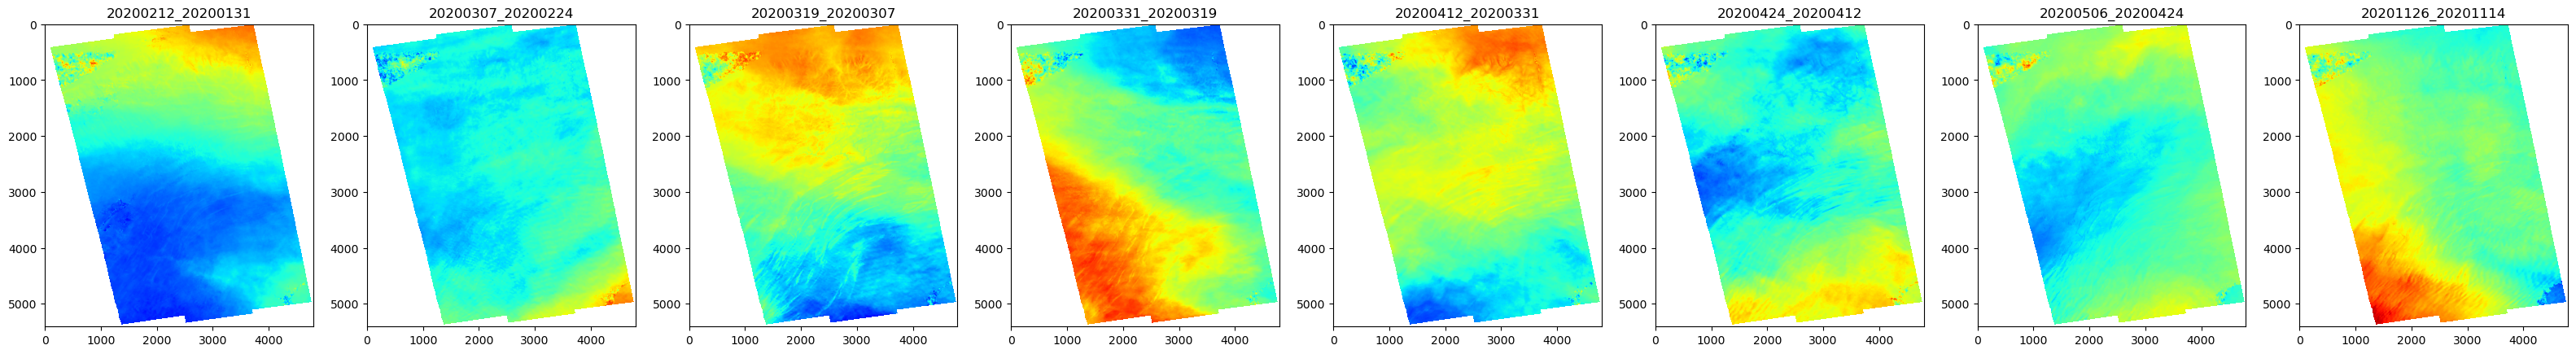

In [34]:
IFG = []
fig, axes = plt.subplots(1, 8, figsize=(40,15))
for i, date in enumerate(ifg_list):
    ifg_path = uw_ifg+date
    # coh_path = coh_ifg+date+'.vrt'
    # with rasterio.open(coh_path) as file:
    #     coh = file.read(1)
    #     mask = coh>0.5
    try:
        with rasterio.open(ifg_path) as file:
            ifg = file.read(1)
            ifg[ifg==0.0] = np.nan
            ifg = convert_rad(ifg, 5.6/100)
            a = axes[i].imshow(ifg, cmap='jet')
            axes[i].title.set_text(date)
            IFG.append(ifg)
    except:
        continue
    """ Iterate column's axes"""
# axes.colorbar(a, label='(m)', orientation='horizontal')
plt.show()

In [18]:
ifg__ = rasterio.open(dates[::2][0])
lon_min, lat_min, lon_max, lat_max = ifg__.bounds

20200212_20200131


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


8115/8115 [==============================] - 9s 1ms/step


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


8115/8115 [==============================] - 9s 1ms/step
20200307_20200224


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


8115/8115 [==============================] - 8s 1ms/step


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


8115/8115 [==============================] - 9s 1ms/step
20200319_20200307


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


8115/8115 [==============================] - 9s 1ms/step


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


8115/8115 [==============================] - 8s 1ms/step
20200331_20200319


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


8115/8115 [==============================] - 9s 1ms/step


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


8115/8115 [==============================] - 9s 1ms/step
20200412_20200331


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


8115/8115 [==============================] - 9s 1ms/step


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


8115/8115 [==============================] - 8s 1ms/step
20200424_20200412


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


8115/8115 [==============================] - 9s 1ms/step


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


8115/8115 [==============================] - 9s 1ms/step
20200506_20200424


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


8115/8115 [==============================] - 9s 1ms/step


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


8115/8115 [==============================] - 9s 1ms/step
20201126_20201114


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


8115/8115 [==============================] - 9s 1ms/step


/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


8115/8115 [==============================] - 9s 1ms/step


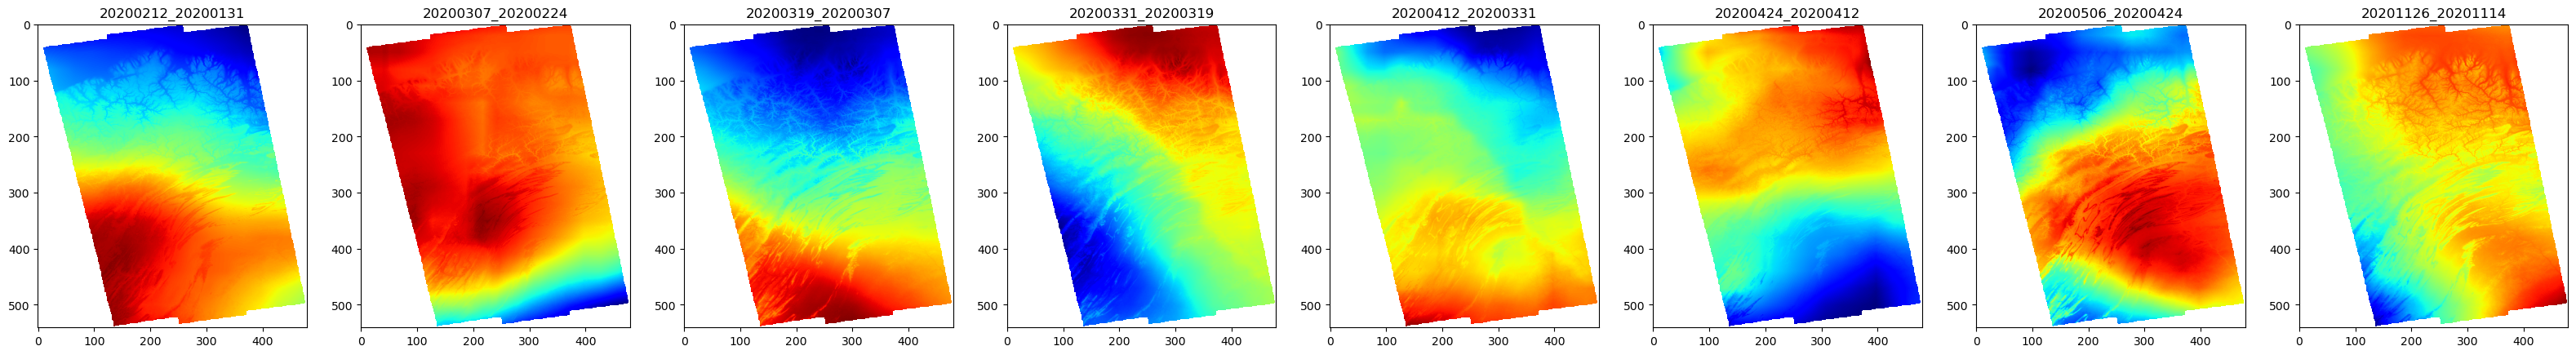

In [35]:
TD_list = []
fig, axes = plt.subplots(1, 8, figsize=(40,15))
for i, date in enumerate(ifg_list):
    print(date)
    # print('Reading in ...')
    ifg, grid = focus_bound(uw_ifg + date, lon_min, lat_min, lon_max,
                            lat_max)
    # print('IFG - done!')
    dem, dem_grid = Resamp_rasterio('../InSAR/Pennsylvania/Extracted/DEM/SRTM_3arcsec_uncropped.tif', lon_min,
                                    lat_min, lon_max,
                                    lat_max, ifg)
    # print('DEM - done!')
    # los, _ = Resamp_rasterio('../InSAR/Pennsylvania/Angle/los.rdr', lon_min, lat_min, lon_max, lat_max, ifg)
    # print('LOS - done!')
    # print('DEM: ', dem_grid[0:5])
    # Create a mask for IFG
    mask = ifg==0
    ifg[~mask] = np.nan
    lon = dem_grid[:,0].reshape(ifg.shape)
    # lon[mask] = np.nan
    lat = dem_grid[:,-1].reshape(ifg.shape)
    # lat[mask] = np.nan
    
    # Get all the x,y coordinate
    # x = list(set(grid[:, 0]))
    # x.sort()
    # y = list(set(grid[:, 1]))
    # y.sort()
    
    # # Get date and wm
    date1, date2 = get_datetime(date)
    dem[mask] = np.nan
    x = lon[::10,::10][0,:]
    x.sort()
    y = lat[::10,::10][:,0]
    y.sort()
    XY = np.meshgrid(x,y)
    # print('Loading Weather model and interp weather model to the right coordinate')
    # print('Day1...')
    with xr.load_dataset(" ".join(glob.glob(weather_file_path + 'ERA-5_{date}_T23_00_00*[A-Z].nc'.format(date=date1)))) as wm:
        # Day1 WM (PTe) parameters
        P1 = wm.p.interp(x=x, y=y, z=hgtlvs)
        T1 = wm.t.interp(x=x, y=y, z=hgtlvs)
        e1 = wm.e.interp(x=x, y=y, z=hgtlvs)
    # print('Done!')
    # print('Day2...')
    with xr.load_dataset(" ".join(glob.glob(weather_file_path + 'ERA-5_{date}_T23_00_00*[A-Z].nc'.format(date=date2)))) as wm:
        # Day1 WM (PTe) parameters
        P2 = wm.p.interp(x=x, y=y, z=hgtlvs)
        T2 = wm.t.interp(x=x, y=y, z=hgtlvs)
        e2 = wm.e.interp(x=x, y=y, z=hgtlvs)
    # print('Done!')
    # print('')
    # print('Make data array for ML prediction...')
    Day_1 = np.hstack((XY[1].reshape(-1, 1), dem[::10,::10].ravel().reshape(-1, 1),
                       np.vstack(P1.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51))),
                       np.vstack(T1.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51))),
                       np.vstack(e1.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51)))))
    Day_2 = np.hstack((XY[1].reshape(-1, 1), dem[::10,::10].ravel().reshape(-1, 1),
                       np.vstack(P2.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51))),
                       np.vstack(T2.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51))),
                       np.vstack(e2.transpose('y','x','z').values[::-1,:,:].reshape((-1, 51)))))
    # print('Done!')
    # print('')
    # print('Make prediction...')
    predict_day1, predict_day2 = model.predict(scaler.transform(Day_1)), model.predict(scaler.transform(Day_2))
    TD = (predict_day1 - predict_day2).reshape(dem[::10,::10].shape)
    # TD = TD - TD[300,300]
    TD_list.append(TD)
    # print('Done!')
    
    axes[i].imshow(TD, cmap='jet')
    # axes[i].xlabel('Lon')
    # axes[i].ylabel('Lat')
    # axes[i].axis("off")
    # axes[i].colorbar(label='Total Delay (m)')
    axes[i].title.set_text(date)
plt.show()
    

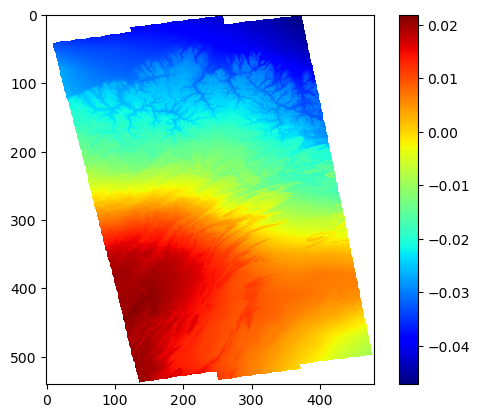

In [48]:
plt.imshow(TD_list[0] - TD_list[0][300,300] , cmap='jet')
plt.colorbar()

In [33]:
TD_list[0][400,200]

0.017556429

In [39]:
np.nanmin(IFG[0][::10,::10]),np.nanmax(IFG[0][::10,::10])

(-0.015595284, 0.16294074)

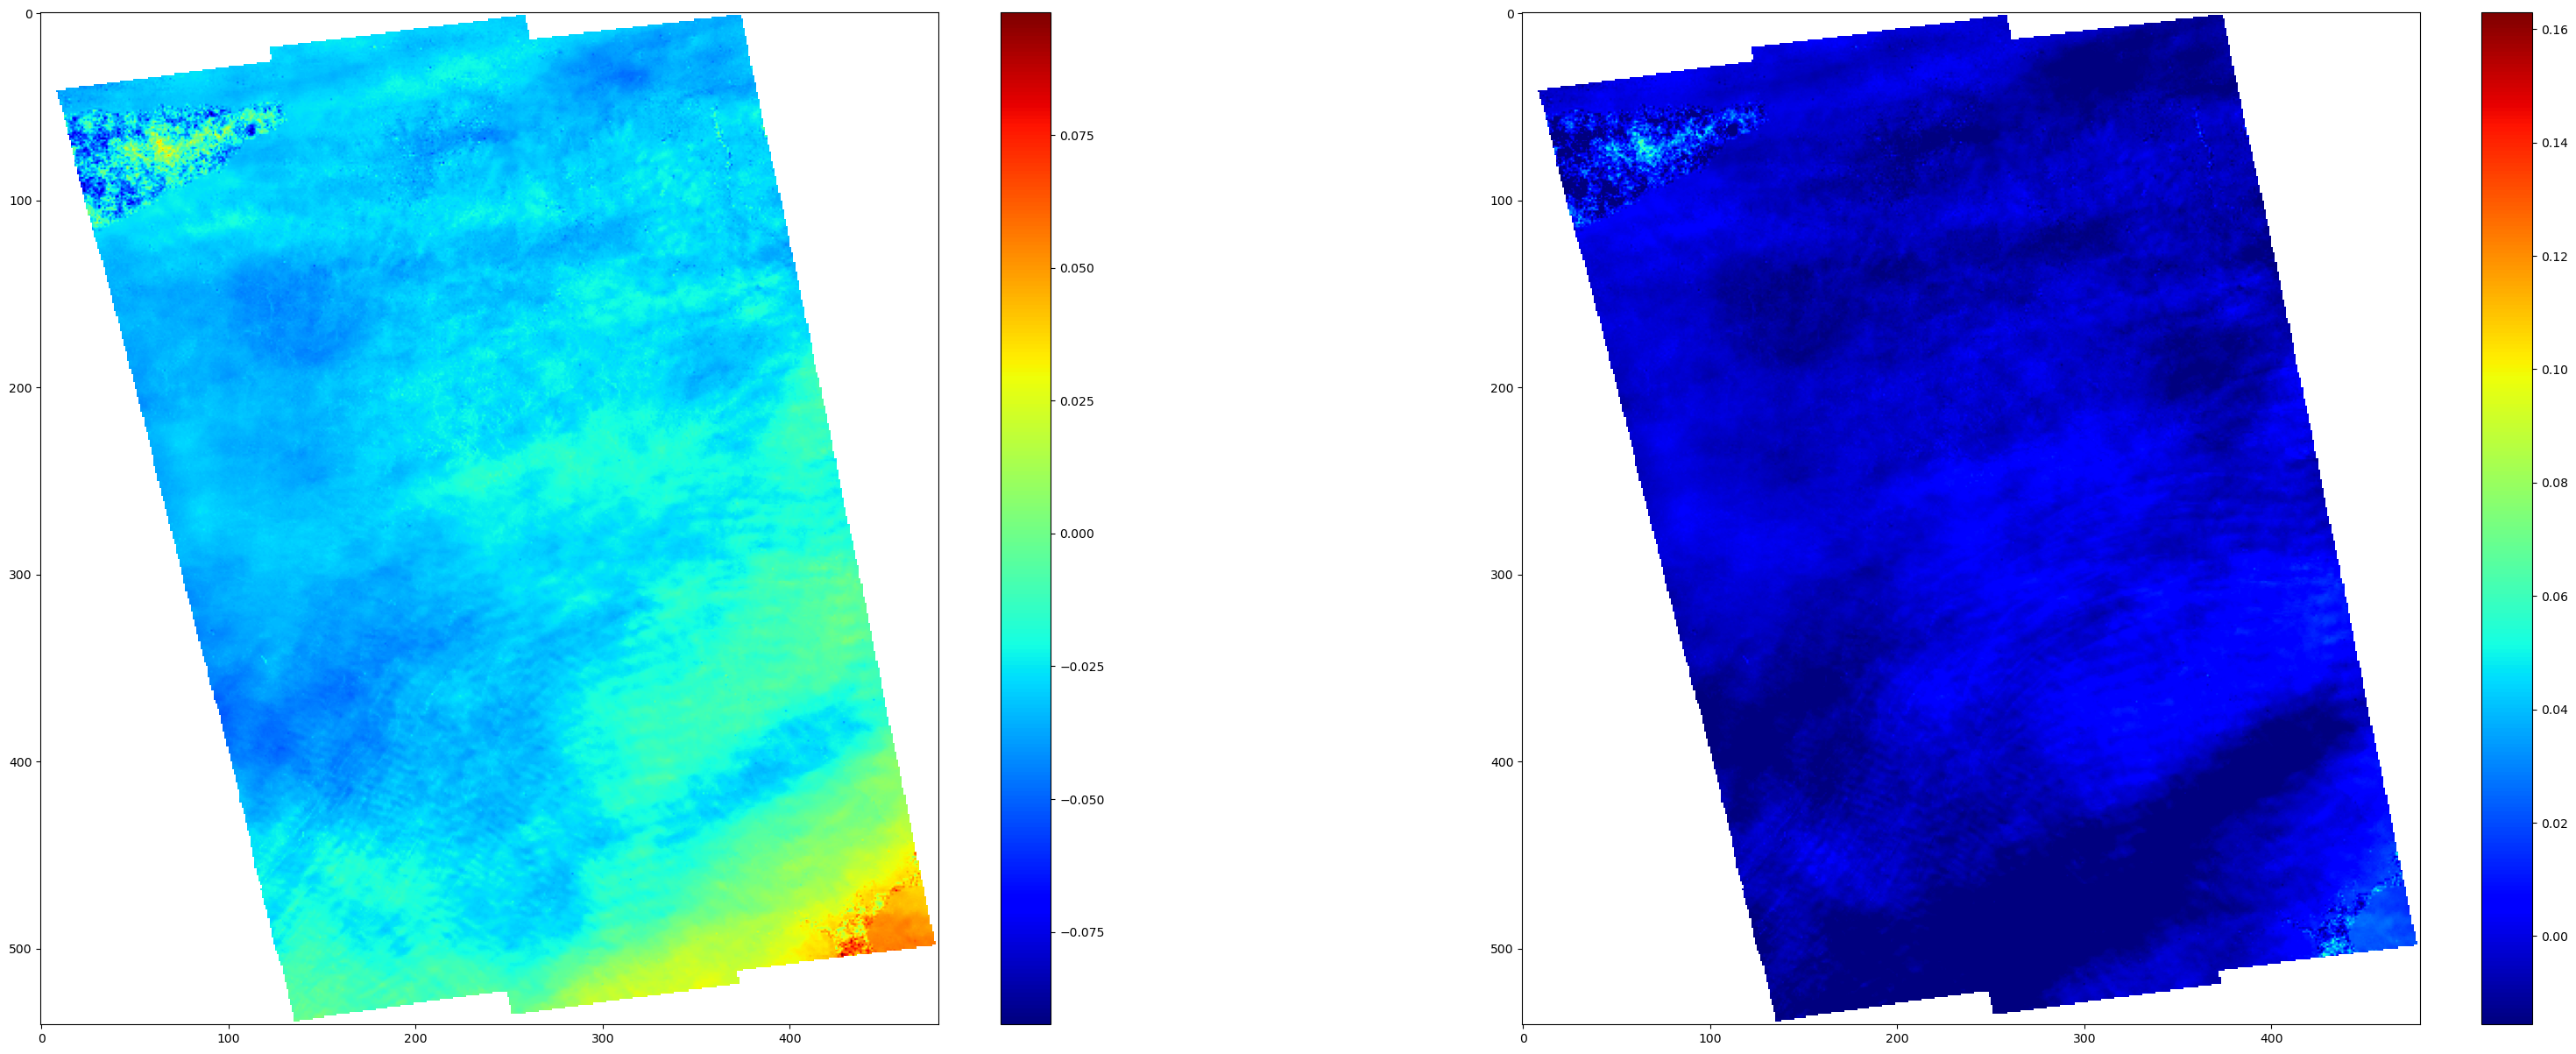

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(40,15))
a = axes[0].imshow(IFG[1][::10,::10], cmap='jet')
plt.colorbar(a)
b = axes[1].imshow((IFG[1][::10,::10] + TD_list[1]) - (IFG[1][::10,::10] + TD_list[1])[300,300], cmap='jet', vmin = np.nanmin(IFG[0][::10,::10]), vmax = np.nanmax(IFG[0][::10,::10]))
plt.colorbar(b)
plt.show()

In [62]:
np.nanstd(IFG[1][::10,::10]), np.nanstd((IFG[1][::10,::10] + TD_list[1]) - (IFG[1][::10,::10] + TD_list[1])[300,300])

(0.014496532, 0.008271966)

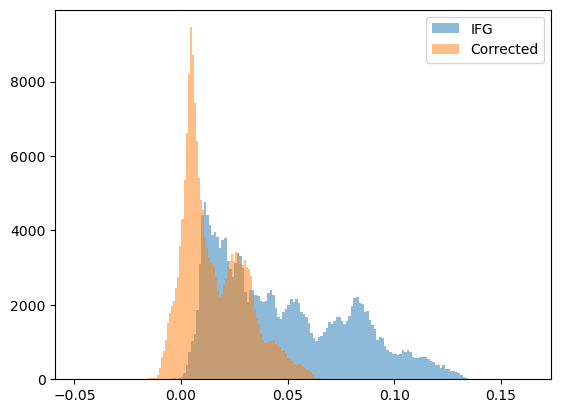

In [60]:
plt.hist(IFG[0][::10,::10].ravel(), bins=150, label='IFG', alpha=0.5)
plt.hist(((IFG[0][::10,::10] + TD_list[0]) - (IFG[0][::10,::10] + TD_list[0])[300,300]).ravel(), bins=150, label='Corrected', alpha=0.5)
plt.legend()
plt.show()

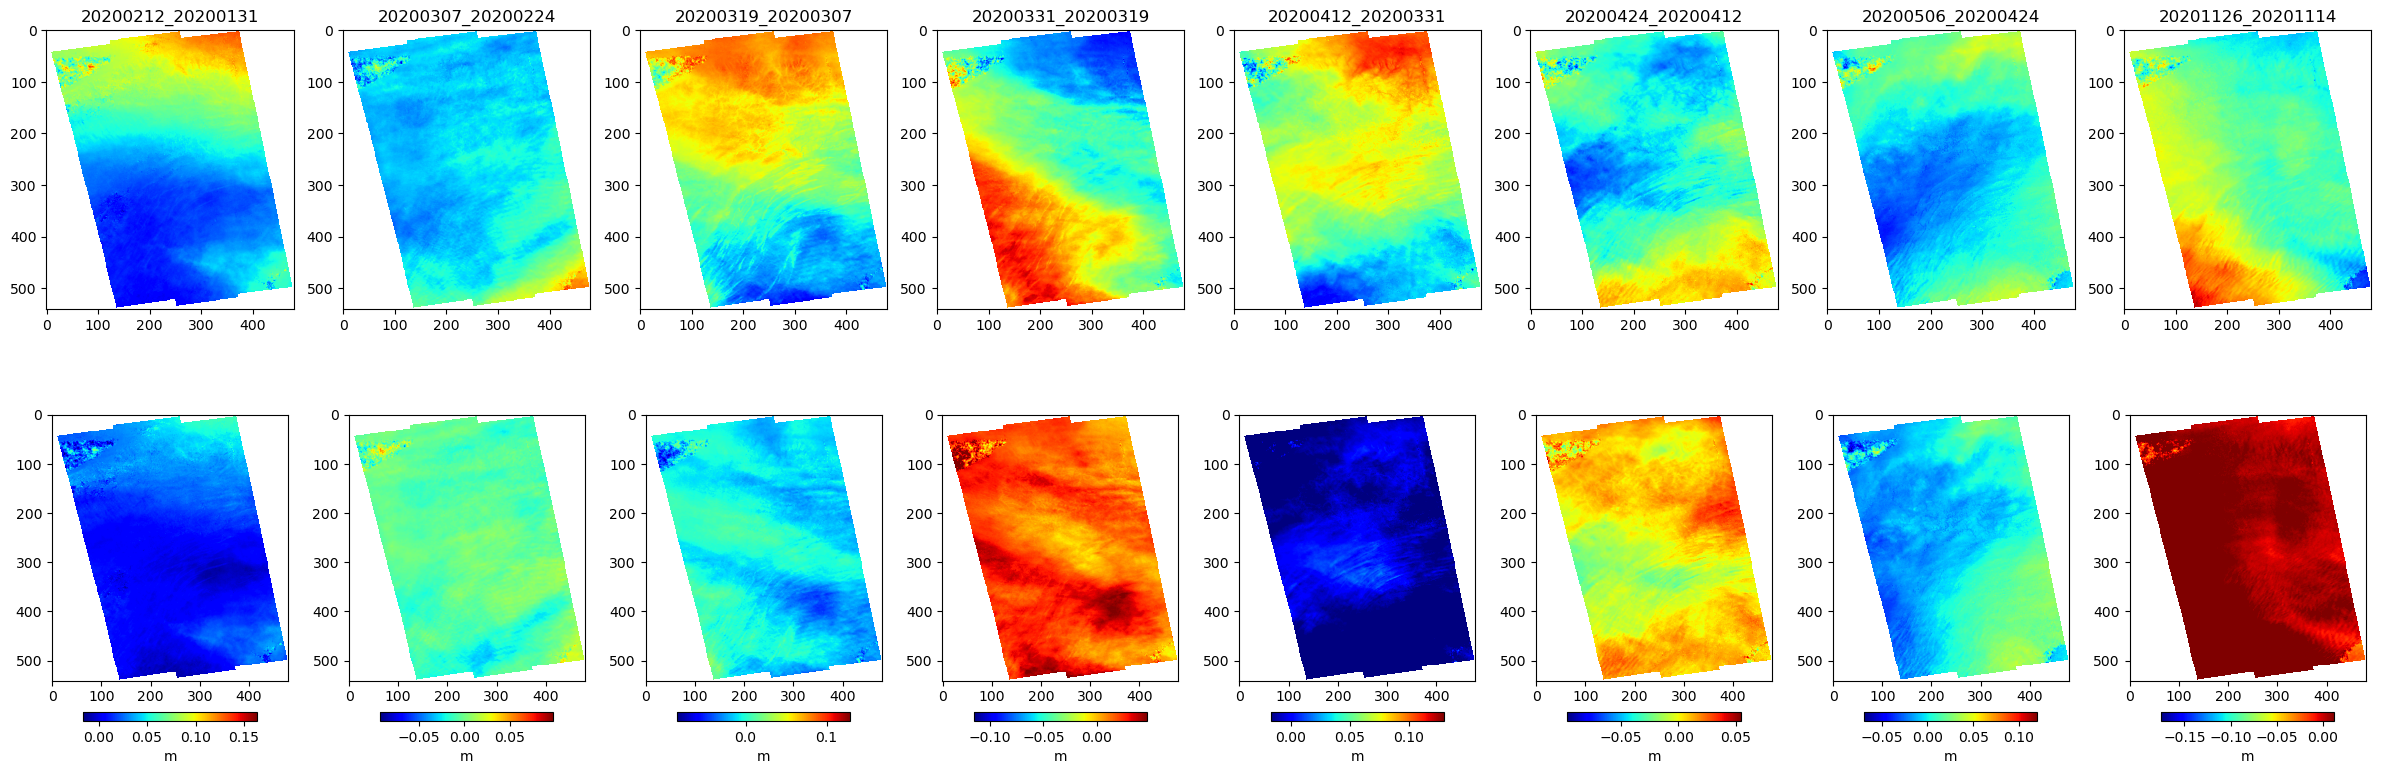

In [128]:
ifg_nn_Corr = []
fig, axes = plt.subplots(2, 8, figsize=(30,10))
for i in range(len(IFG)):
    a = axes[0,i].imshow(IFG[i][::10,::10], cmap='jet')
    # plt.colorbar(a, shrink=.7, pad=.05, label='m')
    axes[0,i].title.set_text(ifg_list[i])
    b = axes[1,i].imshow((IFG[i][::10,::10] + TD_list[i]) - (IFG[i][::10,::10] + TD_list[i])[300,300], cmap='jet', vmin = np.nanmin(IFG[i][::10,::10]), vmax = np.nanmax(IFG[i][::10,::10]))
    plt.colorbar(b, shrink=.7, pad=.09, label='m', orientation='horizontal')
    ifg_nn_Corr.append((IFG[i][::10,::10] + TD_list[i]) - (IFG[i][::10,::10] + TD_list[i])[300,300])
plt.show()

In [100]:
RAiDER_list = []
loc = np.hstack((XY[0].reshape(-1,1), XY[1].reshape(-1,1), dem[::10, ::10].ravel().reshape(-1,1)))
for i, date in enumerate(ifg_list):
    print(date)
    date1, date2 = get_datetime(date)
    with xr.load_dataset(" ".join(glob.glob(weather_file_path + 'ERA-5_{date}_T23_00_00*[A-Z].nc'.format(date=date1)))) as wm:
        hydro_total_1_interp = make_interpretor(wm, 'hydro_total')
        wet_total_1_interp = make_interpretor(wm, 'wet_total')
    with xr.load_dataset(" ".join(glob.glob(weather_file_path + 'ERA-5_{date}_T23_00_00*[A-Z].nc'.format(date=date2)))) as wm:
        hydro_total_2_interp = make_interpretor(wm, 'hydro_total')
        wet_total_2_interp = make_interpretor(wm, 'wet_total')
    
    hydro1 = hydro_total_1_interp(loc).reshape(dem[::10, ::10].shape)
    wet1 = wet_total_1_interp(loc).reshape(dem[::10, ::10].shape)
    hydro2 = hydro_total_2_interp(loc).reshape(dem[::10, ::10].shape)
    wet2 = wet_total_2_interp(loc).reshape(dem[::10, ::10].shape)
    td1 = hydro1 + wet1
    td2 = hydro2 + wet2
    TD = td1 - td2
    RAiDER_list.append(TD)

20200212_20200131
20200307_20200224
20200319_20200307
20200331_20200319
20200412_20200331
20200424_20200412
20200506_20200424
20201126_20201114


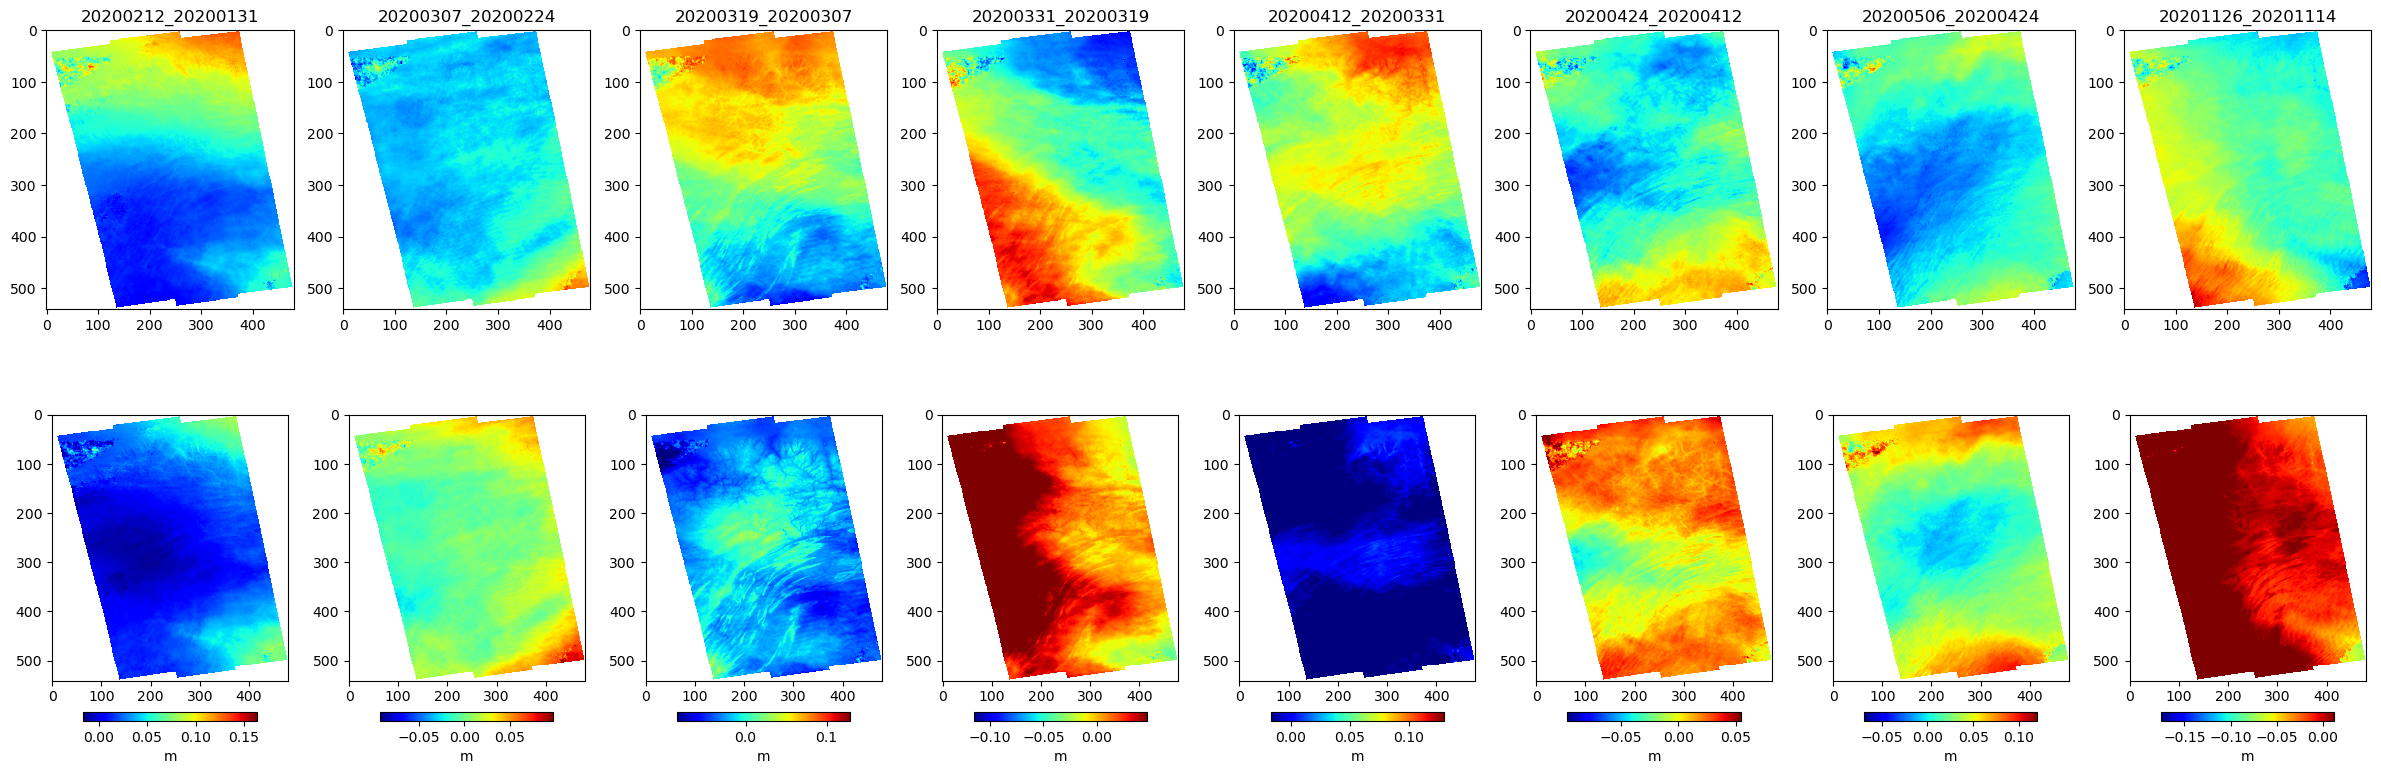

In [129]:
ifg_raider_Corr = []
fig, axes = plt.subplots(2, 8, figsize=(30,10))
for i in range(len(IFG)):
    a = axes[0,i].imshow(IFG[i][::10,::10], cmap='jet')
    # plt.colorbar(a, shrink=.7, pad=.05, label='m')
    axes[0,i].title.set_text(ifg_list[i])
    b = axes[1,i].imshow((IFG[i][::10,::10] - RAiDER_list[i]) - (IFG[i][::10,::10] - RAiDER_list[i])[300,300], cmap='jet', vmin = np.nanmin(IFG[i][::10,::10]), vmax = np.nanmax(IFG[i][::10,::10]))
    plt.colorbar(b, shrink=.7, pad=.09, label='m', orientation='horizontal')
    ifg_raider_Corr.append((IFG[i][::10,::10] - RAiDER_list[i]) - (IFG[i][::10,::10] - RAiDER_list[i])[300,300])
plt.show()

In [127]:
ifg_raider_corr

[array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ..

In [107]:
for i in range(len(IFG)):
    og_ifg_std = np.nanstd((IFG[i][::10,::10])) 
    raider_corr_std = np.nanstd((IFG[i][::10,::10] - RAiDER_list[i]) - (IFG[i][::10,::10] - RAiDER_list[i])[300,300]) 
    nn_corr_std = np.nanstd((IFG[i][::10,::10] + TD_list[i]) - (IFG[i][::10,::10] + TD_list[i])[300,300])
    print(ifg_list[i])
    print('Original ifg std:', og_ifg_std)
    print('RAiDER corrected ifg std:', raider_corr_std)
    print('Neural Network corrected ifg:', nn_corr_std)

20200212_20200131
Original ifg std: 0.031480473
RAiDER corrected ifg std: 0.020540753520701324
Neural Network corrected ifg: 0.014987823
20200307_20200224
Original ifg std: 0.014496532
RAiDER corrected ifg std: 0.01681537757944931
Neural Network corrected ifg: 0.008271966
20200319_20200307
Original ifg std: 0.037783764
RAiDER corrected ifg std: 0.020007994674170325
Neural Network corrected ifg: 0.012058929
20200331_20200319
Original ifg std: 0.03168185
RAiDER corrected ifg std: 0.03276039456737277
Neural Network corrected ifg: 0.011411706
20200412_20200331
Original ifg std: 0.023249954
RAiDER corrected ifg std: 0.01458819434761265
Neural Network corrected ifg: 0.013866409
20200424_20200412
Original ifg std: 0.019762611
RAiDER corrected ifg std: 0.017118074398470018
Neural Network corrected ifg: 0.012123507
20200506_20200424
Original ifg std: 0.01865199
RAiDER corrected ifg std: 0.025267487281143555
Neural Network corrected ifg: 0.017056538
20201126_20201114
Original ifg std: 0.02263071

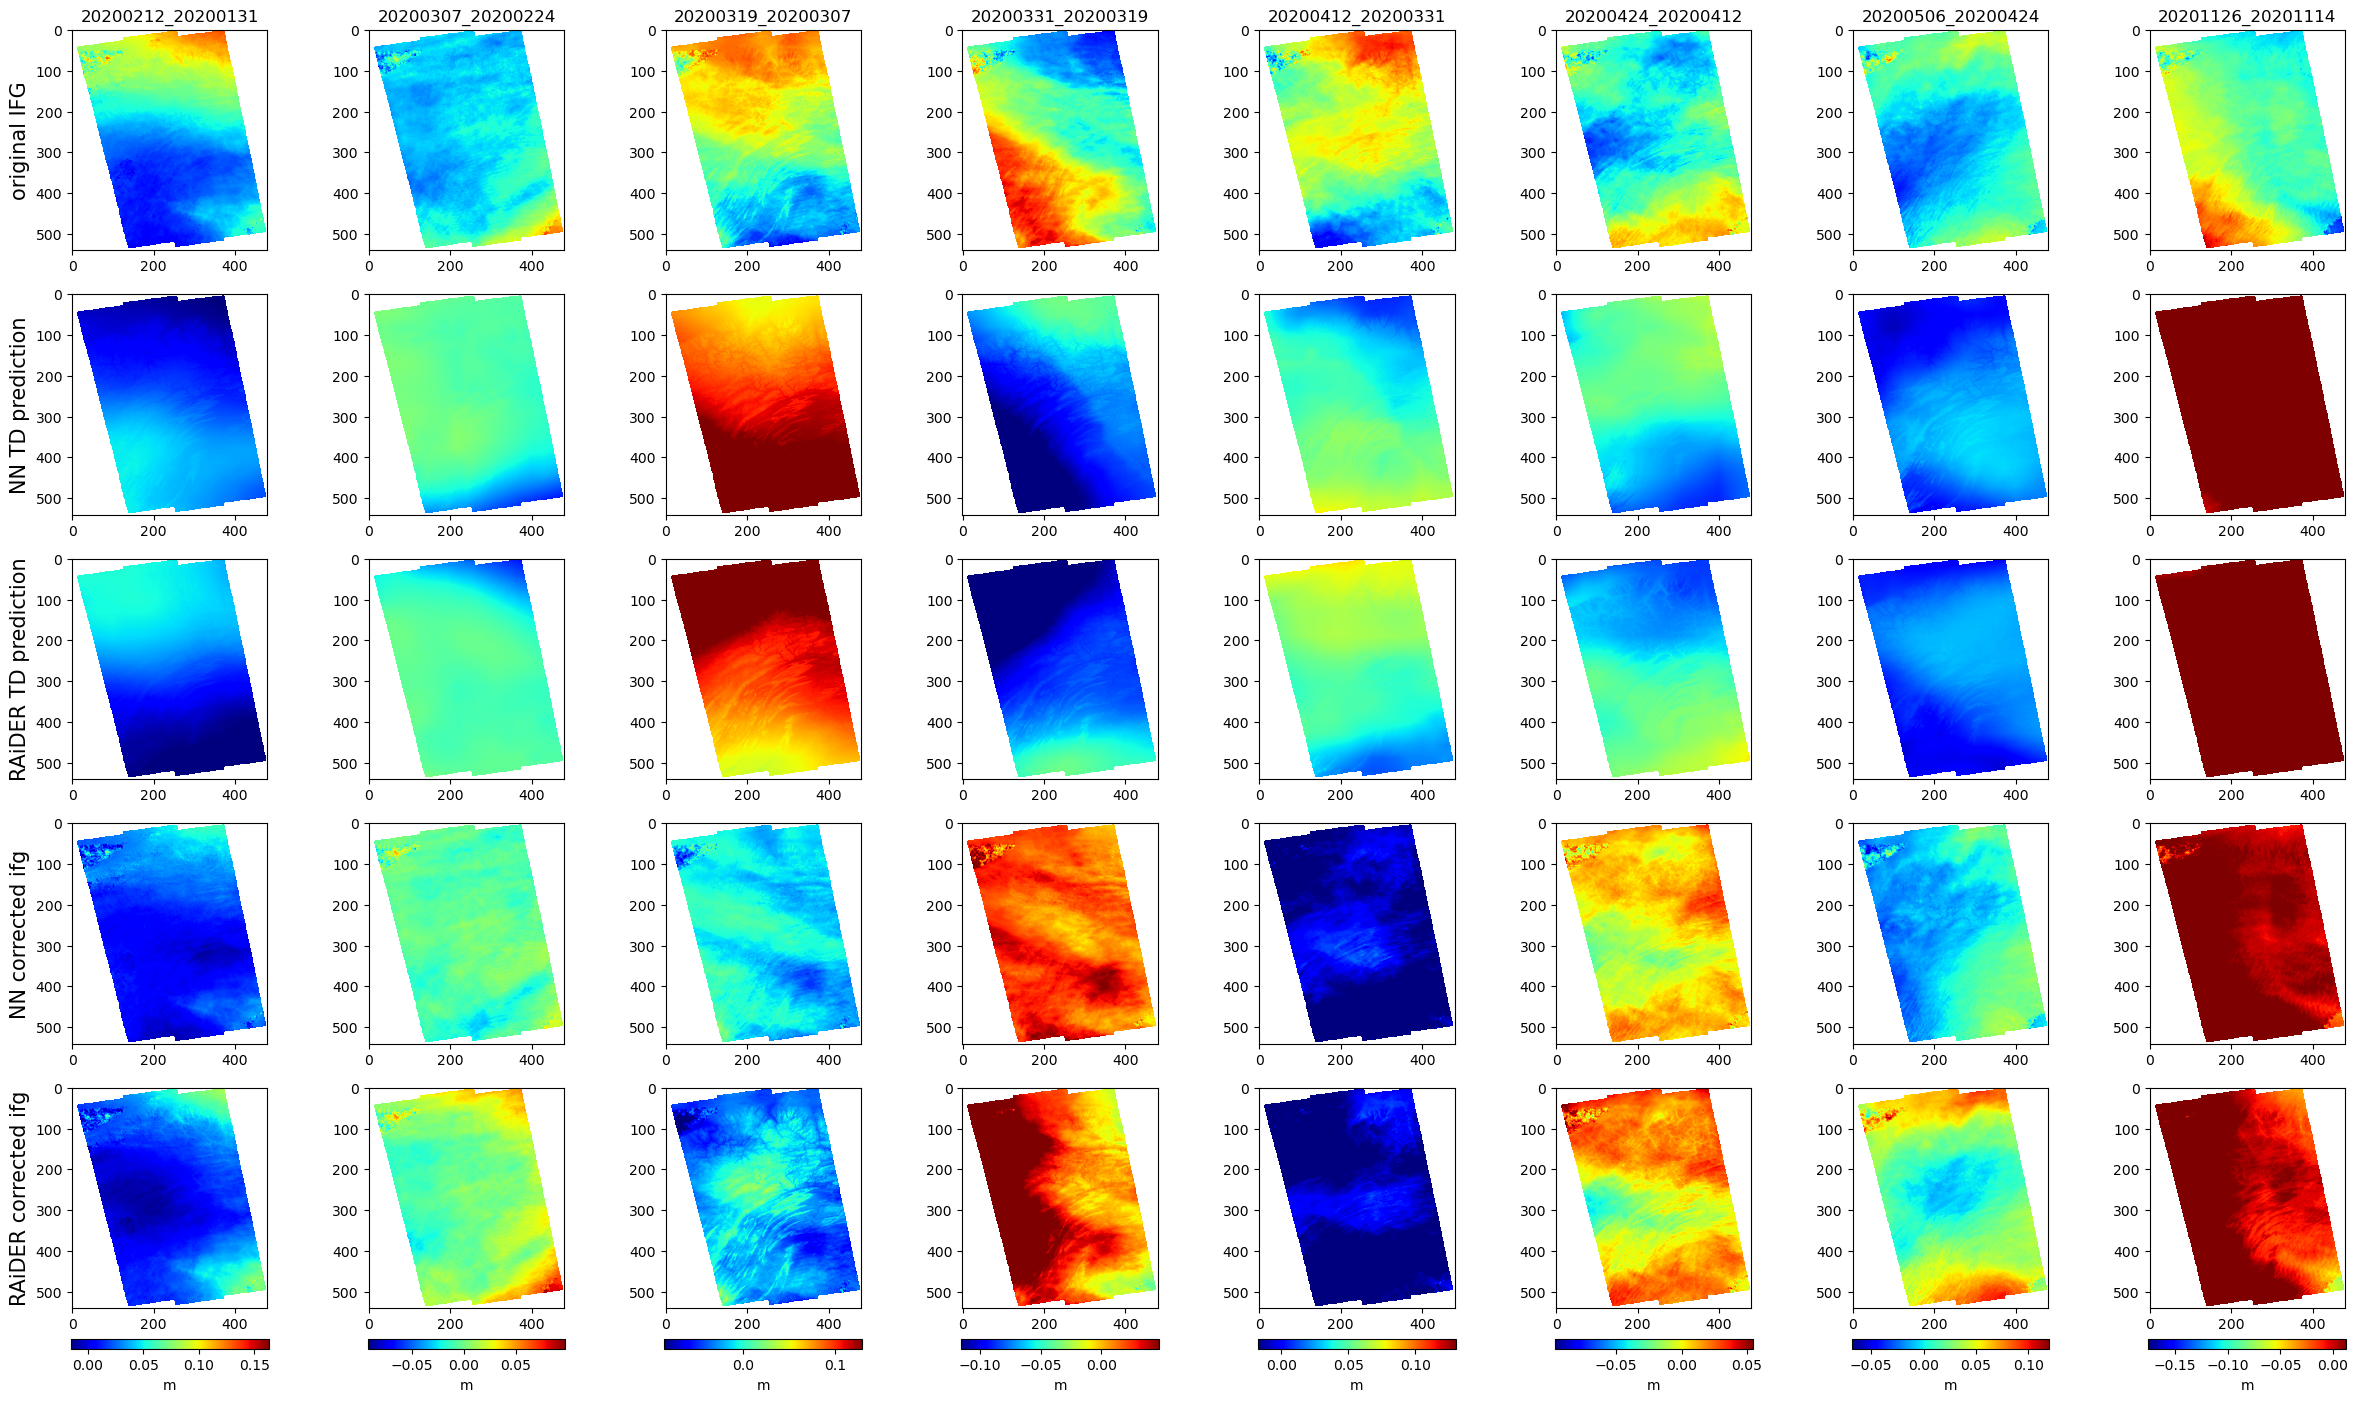

In [162]:
"""
RAiDER_list = List of RAiDER TD prediction of each ifg date
TD_list = List of NN TD prediction of each ifg date
ifg_nn_corr = List of NN corrected ifg of each ifg date
ifg_raider_corr = List of RAiDER corrected ifg of each ifg date
"""
ifg_raider_corr=[]
fig, axes = plt.subplots(5, 8, figsize=(30,20))
for i in range(len(IFG)):
    a = axes[0,i].imshow(IFG[i][::10,::10], cmap='jet')
    axes[0,i].title.set_text(ifg_list[i])
    b = axes[1,i].imshow(TD_list[i], cmap='jet', vmin = np.nanmin(IFG[i][::10,::10]), vmax = np.nanmax(IFG[i][::10,::10]))
    c = axes[2,i].imshow(RAiDER_list[i], cmap='jet', vmin = np.nanmin(IFG[i][::10,::10]), vmax = np.nanmax(IFG[i][::10,::10]))
    d = axes[3,i].imshow(ifg_nn_Corr[i], cmap='jet', vmin = np.nanmin(IFG[i][::10,::10]), vmax = np.nanmax(IFG[i][::10,::10]))
    e = axes[4,i].imshow(ifg_raider_Corr[i], cmap='jet', vmin = np.nanmin(IFG[i][::10,::10]), vmax = np.nanmax(IFG[i][::10,::10])) 
    fig.colorbar(a, ax=axes[:, i], shrink=0.8, pad=0.02, orientation='horizontal', label='m')
    if i == 0:
        axes[0,i].set_ylabel('original IFG', fontsize=15)
        axes[1,i].set_ylabel('NN TD prediction', fontsize=15)
        axes[2,i].set_ylabel('RAiDER TD prediction', fontsize=15)
        axes[3,i].set_ylabel('NN corrected ifg', fontsize=15)
        axes[4,i].set_ylabel('RAiDER corrected ifg', fontsize=15)
    else:
        pass
plt.show()

In [164]:
import numpy as np
import scipy.interpolate as interp
import pyproj

def tropo_correction(insar_data, lat, lon, height):
    """
    Performs tropospheric correction for InSAR data using the Saastamoinen model.
    
    Parameters:
    insar_data (ndarray): InSAR data to be corrected (in meters)
    lat (ndarray): Latitude array corresponding to the InSAR data
    lon (ndarray): Longitude array corresponding to the InSAR data
    height (ndarray): Height array corresponding to the InSAR data (in meters)
    
    Returns:
    ndarray: InSAR data corrected for tropospheric delay (in meters)
    """
    
    # Define constants
    P0 = 1013.25  # Standard sea-level pressure in hPa
    T0 = 288.15   # Standard temperature at sea level in K
    g = 9.80665   # Acceleration due to gravity in m/s^2
    Rd = 287.058  # Gas constant for dry air in J/(kg K)
    a = 6378137   # Semi-major axis of the Earth in meters
    e2 = 0.00669438  # Square of the first eccentricity
    
    # Convert latitude and longitude to UTM
    utm_proj = pyproj.Proj(proj='utm', zone=10, ellps='WGS84', datum='WGS84')
    x, y = utm_proj(lon, lat)
    
    # Compute the height above the ellipsoid
    geoid_proj = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
    x_ecef, y_ecef, z_ecef = pyproj.transform(utm_proj, geoid_proj, x, y, height)
    r = np.sqrt(x_ecef**2 + y_ecef**2 + z_ecef**2)
    h = np.sqrt(x_ecef**2 + y_ecef**2 + (z_ecef**2)*(1-e2)) - a*np.sqrt(1-e2)
    
    # Interpolate the standard atmosphere data
    altitudes = np.arange(0, 20001, 250)
    pressures = np.array([1013.25, 898.76, 795.15, 701.38, 616.48, 539.47, 469.45, 405.62, 347.21, 293.54, 244.97, 201.89,
                          163.72, 129.96, 100.14, 73.83, 50.60, 30.99, 14.55, 1.69])
    temperatures = np.array([288.15, 281.65, 275.15, 268.65, 262.15, 255.65, 249.15, 242.65, 236.15, 229.65, 223.15, 216.65,
                             216.65, 216.65, 216.65, 216.65])


In [166]:
tropo_correction(IFG[0][::10,::10], lat, lon, dem[::10,::10])

/tmp/ipykernel_28371/3932358645.py:33: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_ecef, y_ecef, z_ecef = pyproj.transform(utm_proj, geoid_proj, x, y, height)


ProjError: x, y, z, and time must be same size if included.